# PEtab and Parameter Estimation for Kholodenko's Model of EGFR Pathway

In [2]:
import petab
import fides
import os
import libsbml
import amici
import amici.petab_simulate
import matplotlib.pyplot as plt
import pypesto
import pypesto.optimize as optimize
import pypesto.petab
import petab.visualize
import pypesto.visualize as visualize
from petab.visualize import plot_data_and_simulation
from petab.visualize import plot_petab_problem
import importlib
import sys

In [3]:
# import to petab
petab_problem = petab.Problem.from_yaml(
    
   "EGFR_showdata/EGFR.yaml"
)
importer = pypesto.petab.PetabImporter(petab_problem)
# import to pypesto
problem = importer.create_problem()
model = importer.create_model(verbose=False)


Using existing amici model in folder /home/zarifeh/Downloads/Post_doc/Energy modeling/EGFR Model/PEtab for EGFR/amici_models/EGFR_KHOLODENKO_TEST1.
Using existing amici model in folder /home/zarifeh/Downloads/Post_doc/Energy modeling/EGFR Model/PEtab for EGFR/amici_models/EGFR_KHOLODENKO_TEST1.


In [16]:
def get_optimizer(library, solver):
    """Constructs Optimizer given and optimization library and optimization
    solver specification"""
    options = {'maxiter': 100}

    if library == 'scipy':
        optimizer = optimize.ScipyOptimizer(method=solver, options=options)
    elif library == 'ipopt':
        optimizer = optimize.IpoptOptimizer()
    elif library == 'dlib':
        optimizer = optimize.DlibOptimizer(options=options)
    elif library == 'pyswarm':
        optimizer = optimize.PyswarmOptimizer(options=options)
    elif library == 'cmaes':
        optimizer = optimize.CmaesOptimizer(options=options)
    elif library == 'scipydiffevolopt':
        optimizer = optimize.ScipyDifferentialEvolutionOptimizer(
            options=options
        )
    elif library == 'pyswarms':
        optimizer = optimize.PyswarmsOptimizer(options=options)
    elif library == 'nlopt':
        optimizer = optimize.NLoptOptimizer(method=solver, options=options)
    elif library == 'fides':
        options[fides.Options.SUBSPACE_DIM] = solver[1]
        optimizer = optimize.FidesOptimizer(
            options=options, hessian_update=solver[0]
        )

In [6]:
#optimizer= optimize.ScipyOptimizer(method='ls_trf')
#result = optimize.minimize(problem, n_starts=10, filename=None)

#model.SteadyStateSensitivityMethod = amici.SteadyStateSensitivityMode.simulationFSA
# create optimizer object which contains all information for doing the optimization
options = {'maxiter': 2000}
optimizer = optimize.FidesOptimizer(options=options)

#optimizer.solver = "ls_trf"
# 'trust-exact'

#optimizer = optimize.ScipyOptimizer()

#engine = pypesto.engine.SingleCoreEngine()
engine = pypesto.engine.MultiProcessEngine()

# do the optimization
result = optimize.minimize(
    problem=problem, optimizer=optimizer, n_starts=1
)


Engine set up to use up to 4 processes in total. The number was automatically determined and might not be appropriate on some systems.
  0%|          | 0/1 [00:00<?, ?it/s]2022-05-03 11:40:07,948 - fides - INFO -  iter |    fval    | fval diff | pred diff | tr ratio  |  delta   |  ||g||   | ||step|| | step | accept
2022-05-03 11:40:07,949 - fides - INFO -     0 | +5.182E+08 |    NaN    |    NaN    |    NaN    | 1.00E+00 | 9.06E+07 |   NaN    | NaN  | 1
2022-05-03 11:40:09,569 - fides - INFO -     1 | +3.782E+08 | -1.40E+08 | -1.38E+08 | +9.19E-01 | 1.00E+00 | 9.06E+07 | 2.00E+00 | 2d   | 1
2022-05-03 11:40:11,119 - fides - INFO -     2 | +1.521E+08 | -2.26E+08 | -1.39E+08 | +1.25E+00 | 2.00E+00 | 7.82E+07 | 5.90E+00 | 2d   | 1
2022-05-03 11:40:12,212 - fides - INFO -     3 | +5.673E+07 | -9.54E+07 | -6.12E+07 | +1.09E+00 | 4.00E+00 | 1.38E+08 | 3.77E+01 | trr  | 1
2022-05-03 11:40:13,203 - fides - INFO -     4 | +1.723E+07 | -3.95E+07 | -2.59E+07 | +1.32E+00 | 8.00E+00 | 2.76E+08 | 7.7

# Visualization

Using existing amici model in folder /home/zarifeh/Downloads/Post_doc/Energy modeling/EGFR Model/PEtab for EGFR/amici_models/EGFR_KHOLODENKO_TEST1.


Parameters are estimated to be (linear scale):
r1_k1f: 0.0013620936924188612
r1_k1b: 2.0394271531103618e-12
r2_k2f: 19.999999999820975
r2_k2b: 7.68149032705832e-05
r3_k3f: 0.003107483625247007
r3_k3b: 19.99980024724173
r4_V4: 1480.3815435859233
r4_K4: 7.452134742998447
r5_k5f: 2.151777853827893
r5_k5b: 6.129328082742058
r6_k6f: 19.999999596407452
r6_k6b: 2.0998742939028177e-07
r7_k7f: 11.472032343825509
r7_k7b: 4.999999999933144
r8_V8: 0.2548411520025651
r8_K8: 0.0002808793213882055
r9_k9f: 0.09363321677240946
r9_k9b: 0.6468873382538153
r10_k10f: 9.99999999999997
r10_k10b: 0.09726262373047515
r11_k11b: 9.55003093387646e-14
r11_k11f: 3.1761159222262653e-14
r12_k12f: 3.941448914653891e-14
r12_k12b: 0.0024170774127872732
r13_k13f: 2.0503321949165123
r13_k13b: 18.79611933347574
r14_k14f: 9.99999999747932
r14_k14b: 3.2921684411668254e-06
r15_k15f: 1.459060598875163e-05
r15_k15b: 3.887417559159735
r16_V16: 99.68310685712623
r16_K16: 8.219354103946943e-12
r17_k17f: 19.999999998788383
r17_k17b

[Warning] AMICI:NaN: AMICI encountered a NaN value for fxdot[0]!
[Warning] AMICI:NaN: AMICI encountered a NaN value for p[0]!
[Warning] AMICI:NaN: AMICI encountered a NaN value for w[8]!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem



<AxesSubplot:title={'center':'Estimated parameters'}, xlabel='Parameter value', ylabel='Parameter'>

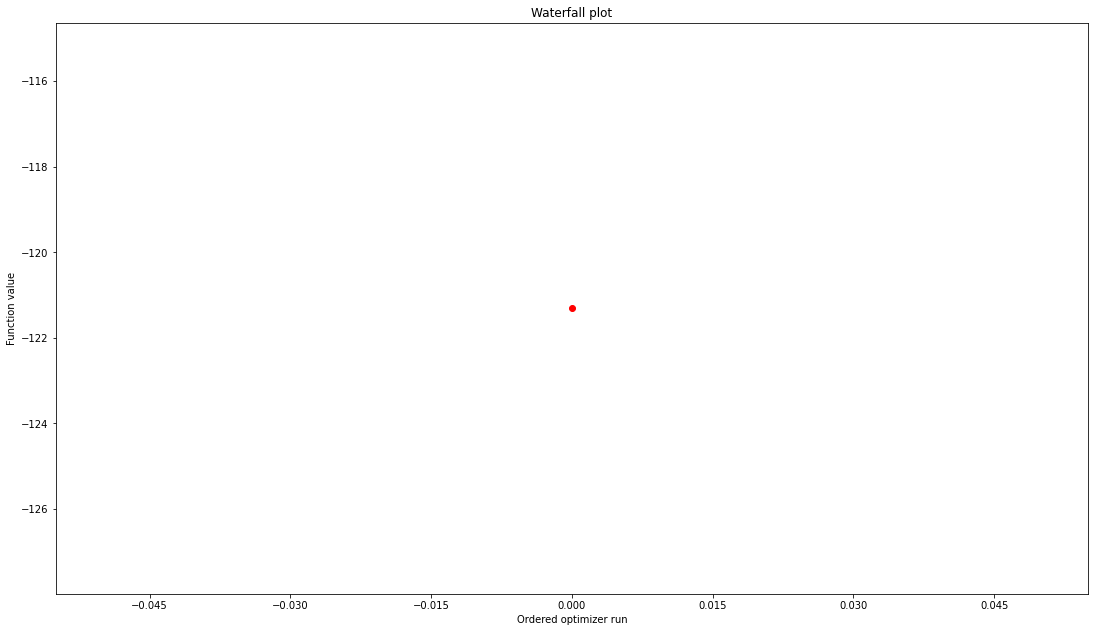

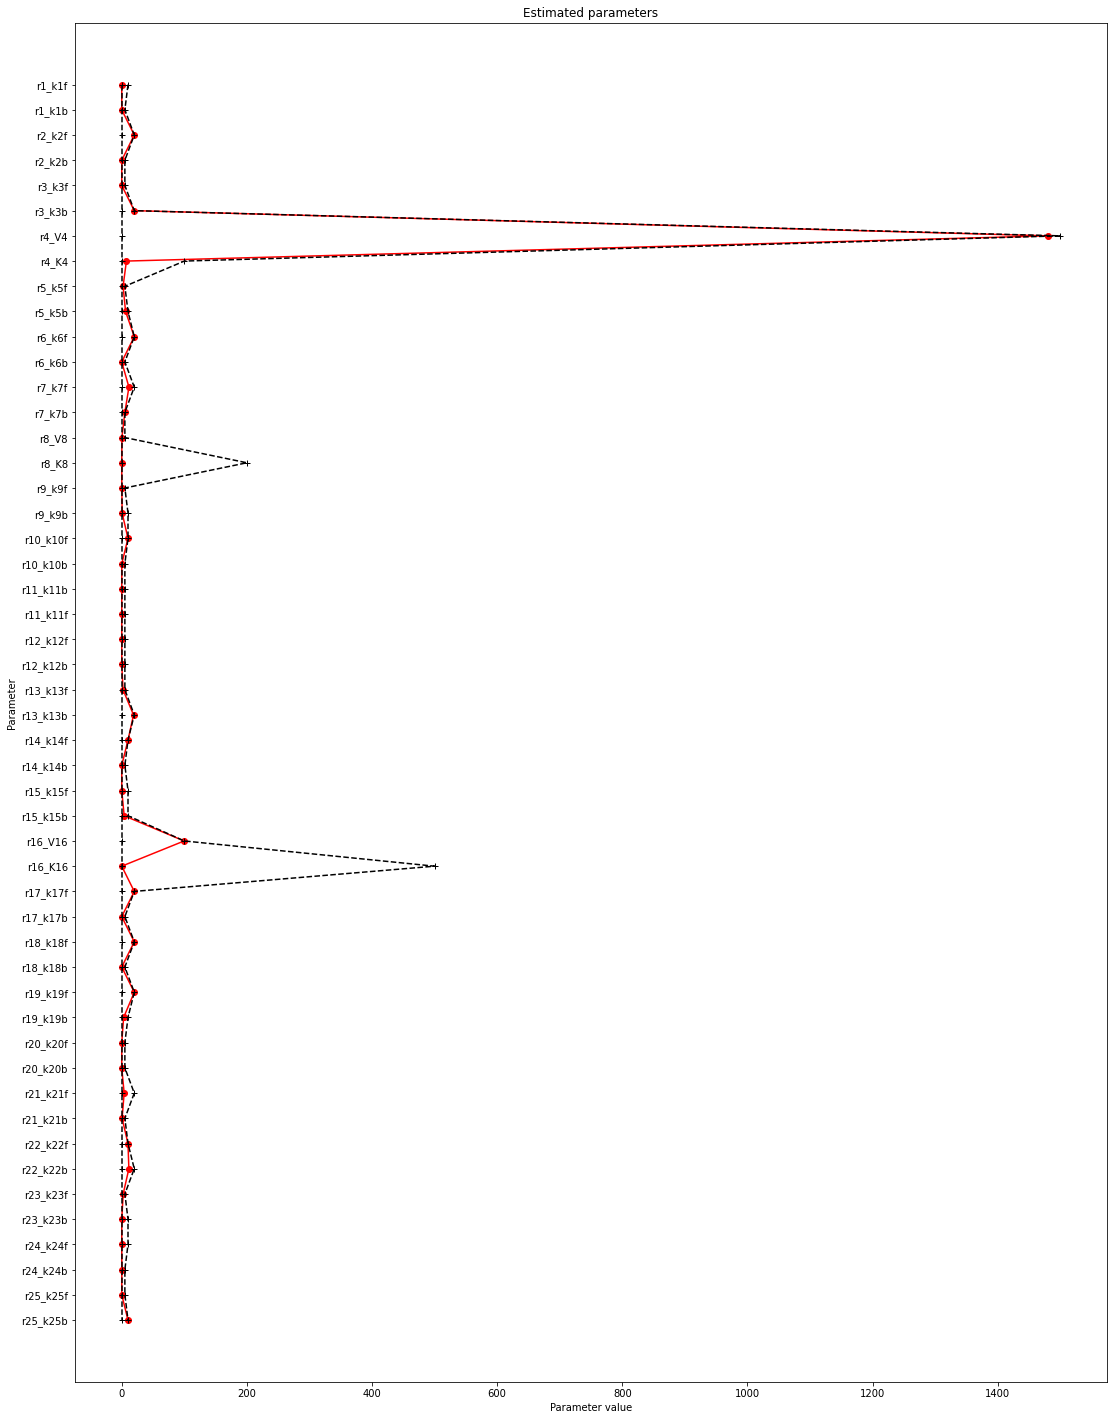

In [7]:
def get_x_mle(optimize_result, pypesto_problem, petab_problem, scaled=True):
    if not scaled:
        scaling = petab.parameters.get_optimization_parameter_scaling(
            petab_problem.parameter_df
        )
    return {
        x_id: (
            petab.parameters.unscale(x_value, scaling[x_id])
            if not scaled
            else x_value
        )
        for x_id, x_value in zip(
            pypesto_problem.x_names, optimize_result.list[0]["x"]
        )
        # if x_id in scaling
    }
x_mle_unscaled_original = get_x_mle(
    result.optimize_result,
    problem,
    petab_problem,
    scaled=False,
)
print("Parameters are estimated to be (linear scale):")
print(
    "\n".join(
        [
            f"{x_id}: {x_value}"
            for x_id, x_value in x_mle_unscaled_original.items()
        ]
    )
)

import libsbml

converter_config = libsbml.SBMLLocalParameterConverter().getDefaultProperties()
petab_problem.sbml_document.convert(converter_config)

obj = importer.create_objective()
ref = visualize.create_references(
    x=petab_problem.x_nominal_scaled, fval=obj(petab_problem.x_nominal_scaled)
)

visualize.waterfall(result, reference=ref, scale_y="lin")
visualize.parameters(result, reference=ref)

# Estimated

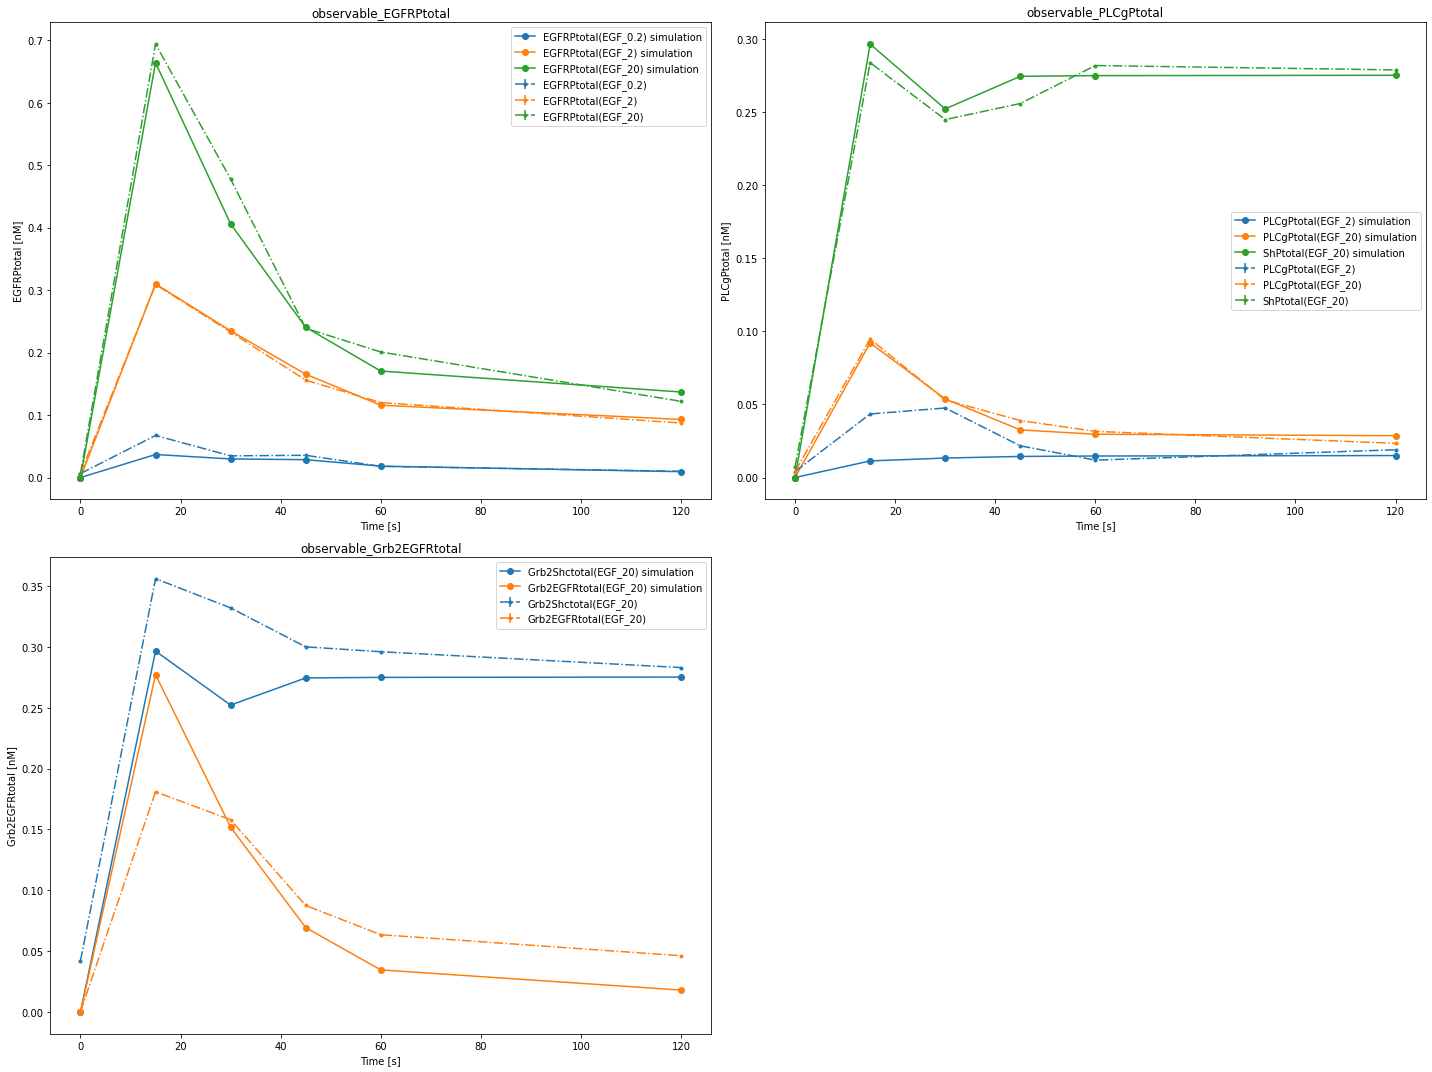

In [8]:
from pypesto.visualize.model_fit import visualize_optimized_model_fit

pp1=visualize_optimized_model_fit(petab_problem=petab_problem, result=result)

# Kholodenko's Model Output

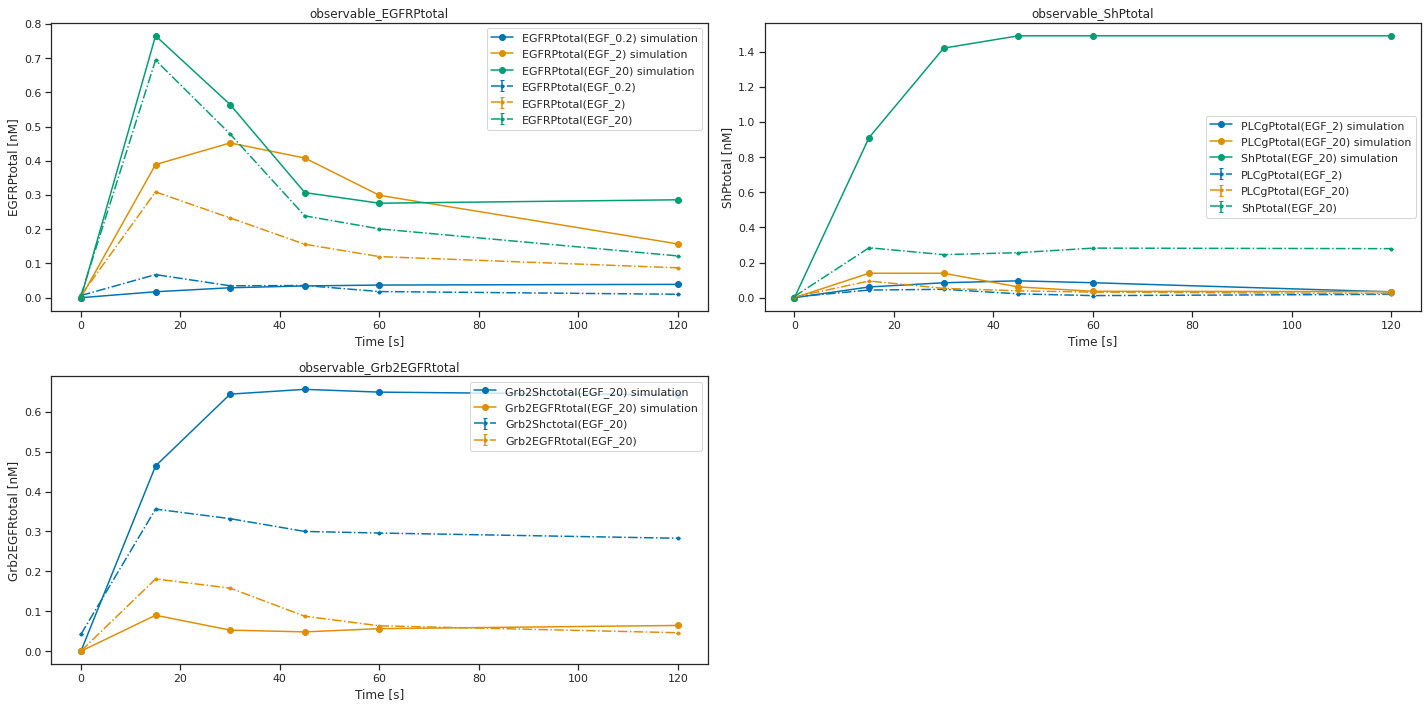

In [7]:
folder = "EGFR_showdata/"

data_file_path = folder + "measurementData_EGFR.tsv"
condition_file_path = folder + "experimentalCondition_EGFR.tsv"
#visualization_file_path = folder + "visualizationSpecification_EGFR.tsv"
visualization_file_path2 = folder + "visualizationSpecification2_EGFR3.tsv"
simulation_file_path = folder + "simulatedData_EGFR.tsv"
pp2=petab.visualize.plot_petab_problem(
  petab_problem,
  simulation_file_path,
  data_file_path
)


In [33]:
df = result.optimize_result.as_dataframe(
    ["fval", "x", "time"],
)
df.head()

,fval,x,time
0,111.852182,"[0.19810401722015328, 5.0, 4.34192239013727, 3...",9.756652
1,111.852182,"[0.1981211541418045, 5.0, 4.34192239013727, 3....",10.063998
2,111.852903,"[0.1923002971571019, 4.854198749762106, 4.3419...",14.589802
3,111.857348,"[0.16319692226261537, 4.116802723056644, 4.341...",6.680129
4,113.157047,"[2.1527330106524496, 0.11479182597866876, 4.34...",5.180254


In [20]:
import pypesto.profile as profile
import numpy as np
optimizer=optimize.ScipyOptimizer(method="ls_trf")

profile_options = profile.ProfileOptions(
    min_step_size=0.0005,
    delta_ratio_max=0.05,
    default_step_size=0.005,
    ratio_min=0.01,
)

result = profile.parameter_profile(
    problem=problem,
    result=result,
    optimizer=optimizer,
   # profile_index=np.array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]),
    result_index=0,
    profile_options=profile_options,
    filename=None,
)

  0%|          | 0/50 [00:22<?, ?it/s]


KeyboardInterrupt: 

In [14]:
import pypesto.profile as profile
import pypesto.sample as sample
result = profile.parameter_profile(
    problem=problem, result=result, optimizer=optimizer, filename=None
)
sampler = sample.AdaptiveMetropolisSampler()
result = sample.sample(
    problem=problem,
    sampler=sampler,
    n_samples=1000,
    result=result,
    filename=None,
)
pypesto.visualize.profiles(result)
pypesto.visualize.sampling_fval_traces(result)

  4%|▍         | 2/50 [08:43<4:06:28, 308.10s/it][Warning] AMICI:NaN: AMICI encountered a NaN value for fxdot[2]!
[Warning] AMICI:Inf: AMICI encountered an Inf value for w[10]!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value for fxdot[2]!
[Warning] AMICI:Inf: AMICI encountered an Inf value for w[10]!
[Warning] AMICI:CVODES:CVode:OTHER: AMICI ERROR: in module CVODES in function CVode : The right-hand side routine failed at the first call. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 0.000000:
AMICI failed to integrate the forward problem

[Warning] AMICI:NaN: AMICI encountered a NaN value for fxdot[2]!
[Warning] AMICI:Inf: AMICI encountered an Inf value for w[10]!
[Warning] AMICI:CVODES:CVode:OTHER: A

KeyboardInterrupt: 

In [7]:
import amici
import amici.plotting
model_name ="EGFR_KHOLODENKO_TEST1_sbml"
model_output_dir= "tmp/" + model_name
sbml_file='/home/zarifeh/Downloads/Post_doc/Energy modeling/EGFR Model/PEtab for EGFR/EGFR_PEtab/EGFR_KHOLODENKO_TEST1_sbml.xml'
sbml_importer = amici.SbmlImporter(sbml_file)
sbml_importer.sbml2amici(model_name, model_output_dir, verbose=False)

KeyboardInterrupt: 

In [46]:
import pypesto.sample as sample

sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(), n_chains=3
)

result = sample.sample(
    problem, n_samples=100, sampler=sampler, result=result, filename=None
)

100%|██████████| 100/100 [00:01<00:00, 74.43it/s]
Elapsed time: 3.232337912000048


In [48]:
ax = visualize.sampling_scatter(result)